In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import json

from modules.interfaces import User, DataBase
from modules.managers import PretradeDataManager, OrderManager, PortfolioManager
from modules.portfolio import *
from modules.tools import *

In [3]:
ac_info = read_json("config/mt5_account.json")["ftmo-demo"]
pre_db_info = read_json("config/postgres_info.json")["pre-trade"]
post_db_info = read_json("config/postgres_info.json")["post-trade"]
params = read_json("config/parameters.json")
asset_allocation = read_json("config/asset_allocation.json")

In [4]:
user = User().login_by_dict(ac_info)
pre_db = DataBase().connect_by_dict(pre_db_info)
post_db = DataBase().connect_by_dict(post_db_info)

Logged in as 1520198341 (FTMO-Demo2)
Connected to pre-trade (localhost:5432)
Connected to post-trade (localhost:5432)


In [5]:
pdm = PretradeDataManager(user, pre_db)
om = OrderManager(user, post_db)
pm = PortfolioManager(om, pdm, asset_allocation, params)

In [6]:
df = pdm.get_universe()

In [8]:
symbols = ["EURUSD", "AUDUSD", "GBPUSD", "NZDUSD"]
close = pd.DataFrame({symbol: pdm.get_bars(symbol).close for symbol in symbols})

In [32]:
def sample_close(s):
  if s is not None:
    return tuple(s.iloc[-1])
    return type(s)
    #return s.iloc[-1]
  #else:
    #return np.nan

In [41]:
daily_close = close.resample('d').last()

In [42]:
monthly_close = daily_close.resample('m').last()

In [78]:
cpi = pd.read_csv("others/data/CPIAUCSL.csv", index_col=0)
cpi.index = pd.to_datetime(cpi.index, format="%d/%m/%Y").to_period("m").end_time.date
cpi.index = pd.DatetimeIndex(cpi.index, name="time")

In [79]:
monthly_close

,EURUSD,AUDUSD,GBPUSD,NZDUSD
time,,,,
2013-05-31,1.29956,0.95679,1.51938,0.79357
2013-06-30,1.30078,0.91340,1.52112,0.77243
2013-07-31,1.32963,0.89406,1.51975,0.79645
2013-08-31,1.32195,0.88971,1.54912,0.77164
2013-09-30,1.35215,0.93224,1.61837,0.82979
...,...,...,...,...
2024-01-31,1.08181,0.65651,1.26862,0.61156
2024-02-29,1.08045,0.64972,1.26242,0.60863
2024-03-31,1.07928,0.65163,1.26236,0.59765


In [80]:
cpi

,cpi,diff,log_diff
time,,,
2013-01-31,231.679,NaN,NaN
2013-02-28,232.937,1.258,0.005415
2013-03-31,232.282,-0.655,-0.002816
2013-04-30,231.797,-0.485,-0.002090
2013-05-31,231.893,0.096,0.000414
...,...,...,...
2023-12-31,308.742,0.718,0.002328
2024-01-31,309.685,0.943,0.003050
2024-02-29,311.054,1.369,0.004411


In [81]:
cpi.cpi.index

DatetimeIndex(['2013-01-31', '2013-02-28', '2013-03-31', '2013-04-30',
               '2013-05-31', '2013-06-30', '2013-07-31', '2013-08-31',
               '2013-09-30', '2013-10-31',
               ...
               '2023-07-31', '2023-08-31', '2023-09-30', '2023-10-31',
               '2023-11-30', '2023-12-31', '2024-01-31', '2024-02-29',
               '2024-03-31', '2024-04-30'],
              dtype='datetime64[ns]', name='time', length=136, freq=None)

<Axes: >

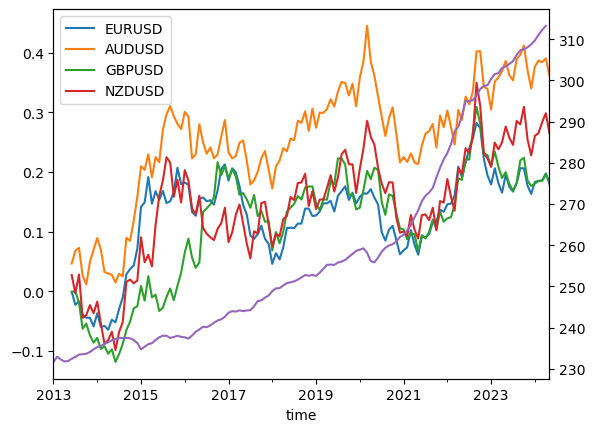

In [84]:
np.log(1/monthly_close).diff().cumsum().plot()
cpi.cpi.plot(secondary_y=True)

In [89]:
np.log(monthly_close).diff().NZDUSD.corr(cpi.log_diff)

0.011633863287866543

In [334]:
symbol1 = 'XAUUSD'
symbol2 = 'XAGUSD'

concat_close = pd.DataFrame({'0':pdm.get_bars(symbol1).close,
                             '1':pdm.get_bars(symbol2).close}).dropna()

In [335]:
uni = pdm.get_universe()
point = uni.set_index("symbol").point
concat_cost = pd.DataFrame(
    {
        "0": pdm.get_bars(symbol1).spread * point[symbol1],
        "1": pdm.get_bars(symbol2).spread * point[symbol2],
    }
).dropna()

In [336]:
start, end = 0, len(concat_close) - 1
idx = concat_close.index

train_size = 6000  # ~1 year
step_size = 120

r2_l = list()
signal_l = list()
comb_pos_l = list()

from sklearn.linear_model import RidgeCV

while True:
    # start ----- (train_size-1) days -----> end
    start_train = idx[start]
    end_train = idx[start + train_size - 1]

    # end+1 ----- (step-1) days -----------> end test
    start_test = idx[start + train_size - train_size]
    end_test = idx[min(start + train_size + step_size - 1, end)]

    org_train_set = concat_close.loc[:end_train]
    train_set = org_train_set.apply(lambda s: get_ewsamples(s, period=train_size))
    test_set = concat_close.loc[start_test:end_test]

    org_train_y, org_train_x = org_train_set["0"], org_train_set[["1"]]
    train_y, train_x = train_set["0"], train_set[["1"]]
    test_y, test_x = test_set["0"], test_set[["1"]]

    # print(f"Train ---- {start_train} : {end_train}")
    model = RidgeCV(cv=5, fit_intercept=False)
    model.fit(train_x, train_y)
    # print(f"    R2 = {model.score(train_x,train_y)}")

    # print(f"Test  ---- {start_test} : {end_test}")
    # print(f"    R2 = {model.score(test_x,test_y)}")
    # print(model.intercept_, model.coef_)

    r2 = model.score(train_x, train_y)
    r2_l.append(r2)

    if True:
        # mean_abs_err = (
        #    (train_y - pd.Series(model.predict(train_x), index=train_x.index))
        #    .abs()
        #    .mean()
        # )
        # var_y = train_y.std() ** 2
        # var_u = (1 - r2) * var_y
        # std_u = var_u**0.5

        h = model.coef_[0]
        pair_value = test_y - h * test_x["1"]
        # exp_value = model.intercept_
        exp_value = pair_value.ewm(train_size, min_periods=train_size + 1).mean()
        std_u = pair_value.ewm(train_size, min_periods=train_size + 1).std()

        signal = ((pair_value - exp_value) / std_u).dropna()
        signal_l.append(signal)

        # long_pos = pd.Series(np.where(signal <= -2, 1, 0), signal.index)
        # short_pos = pd.Series(np.where(signal >= 2, -1, 0), signal.index)
        # pos = long_pos + short_pos
        pos = -signal.clip(upper=2, lower=-2)

        comb_pos = pd.DataFrame({"0": 1 * pos, "1": -h * pos})
        comb_pos_l.append(comb_pos)
    else:
        signal_l.append(pd.Series(0, index=test_y.index))
        comb_pos_l.append(pd.DataFrame({"0": 0, "1": 0}, index=test_y.index))

    # print(f"Testing: [{start_test} - {end_test}]")
    # self.produce_rules(start_lookback, end_test)
    # self.produce_sides(start_test, end_test)
    # self.produce_sizes(start_test, end_test)
    # self.produce_bets(start_test, end_test)

    # sides_l.append(self.sides.loc[start_test:end_test])
    # sizes_l.append(self.sizes.loc[start_test:end_test])
    # bets_l.append(self.bets.loc[start_test:end_test])
    # weighted_bets_l.append(self.weighted_bets.loc[start_test:end_test])

    start += step_size
    if start + train_size >= end:
        break

In [337]:
pos = np.around(pd.concat(comb_pos_l) * 5) / 5
ew_pnl = (pos * np.log(concat_close).diff().shift(-1)).sum(axis=1)
costs = (pos.diff().abs() * concat_cost).sum(axis=1)

In [338]:
def sr(pnl):
  pnl = pnl.resample('d').sum()
  m = pnl.mean()*252
  s = pnl.std()*np.sqrt(252)
  sr = m/s
  return sr
def pf(pnl):
  pnl = pnl.resample('d').sum()
  g = pnl.clip(lower=0).sum()
  l = -pnl.clip(upper=0).sum()
  pf = g/l
  return pf

<Axes: xlabel='time'>

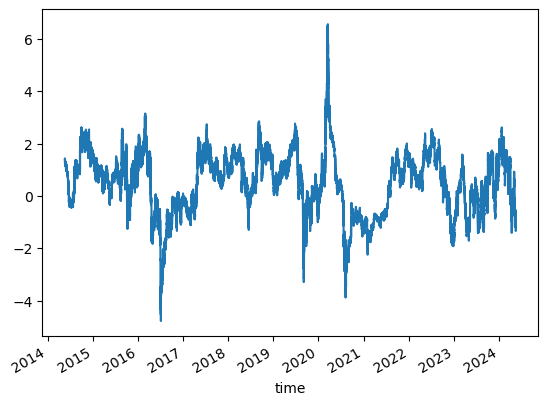

In [339]:
pd.concat(signal_l).plot()

In [340]:
print(sr(ew_pnl),pf(ew_pnl))
#print(sr(pnl),pf(pnl))

1.0682082274692315 1.3653330768927803


<Axes: xlabel='time'>

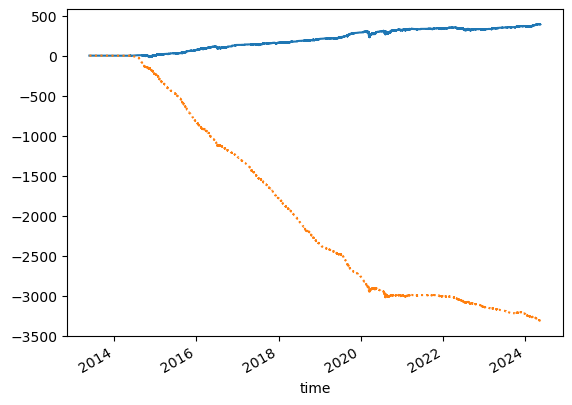

In [341]:
ew_pnl.cumsum().plot()
(ew_pnl-costs).cumsum().plot(linestyle=':')